![Semillero Astrofisica](../logo.png)

---
## Ejemplo: Ecuación de Burguers


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la ecuación de Burgers

\begin{equation}
    \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x} = v\frac{\partial^2 u}{\partial x^2}, \qquad x\in[-1,1], \qquad t\in[0,1].
\end{equation}

Con las condiciones de frontera e iniciales
\begin{equation}
    u(-1,t)=u(1,t)=0, \qquad u(x,0)=-\sin{\pi x}.
\end{equation}


In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

Using backend: tensorflow.compat.v1

2022-10-19 11:18:55.825580: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 11:18:55.828647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 11:18:55.828663: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-19 11:18:57.125884: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 11:18:57.125916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


Definimos el dominio de la ecuación

In [2]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Definimos la ecuación a resolver

In [3]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

Imponemos las condiciones iniciales y de frontera

In [4]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

Creamos la red Neuronal

In [5]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=100, num_initial=100)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

/home/wind/.local/lib/python3.10/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2502=2502. 
  warnings.warn("The balance properties of Sobol' points require "
/home/wind/.local/lib/python3.10/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "


Entrenamos la red

In [6]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.033822 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-19 11:18:58.723706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.245453 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.83e-01, 4.02e-01, 2.29e-01]    [2.83e-01, 4.02e-01, 2.29e-01]    []  


2022-10-19 11:18:58.940019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [4.48e-02, 2.01e-03, 6.01e-02]    [4.48e-02, 2.01e-03, 6.01e-02]    []  
2000      [3.10e-02, 3.06e-04, 4.25e-02]    [3.10e-02, 3.06e-04, 4.25e-02]    []  
3000      [1.44e-02, 1.64e-04, 2.05e-02]    [1.44e-02, 1.64e-04, 2.05e-02]    []  
4000      [4.63e-03, 3.76e-05, 8.43e-03]    [4.63e-03, 3.76e-05, 8.43e-03]    []  
5000      [3.19e-03, 2.68e-05, 3.28e-03]    [3.19e-03, 2.68e-05, 3.28e-03]    []  
6000      [2.28e-03, 1.40e-05, 2.59e-03]    [2.28e-03, 1.40e-05, 2.59e-03]    []  
7000      [1.72e-03, 7.58e-06, 2.21e-03]    [1.72e-03, 7.58e-06, 2.21e-03]    []  
8000      [1.38e-03, 4.46e-06, 1.92e-03]    [1.38e-03, 4.46e-06, 1.92e-03]    []  
9000      [1.20e-03, 3.40e-06, 1.70e-03]    [1.20e-03, 3.40e-06, 1.70e-03]    []  
10000     [1.10e-03, 2.89e-06, 1.53e-03]    [1.10e-03, 2.89e-06, 1.53e-03]    []  

Best model at step 10000:
  train loss: 2.64e-03
  test loss: 2.64e-03
  test metric: []

'train' took 30.830652 s

Compiling model...
'compile' took 0.139449 s

Trainin

Saving loss history to /home/wind/Desktop/PINNs/AD_PINNS_presentation/loss.dat ...
Saving training data to /home/wind/Desktop/PINNs/AD_PINNS_presentation/train.dat ...
Saving test data to /home/wind/Desktop/PINNs/AD_PINNS_presentation/test.dat ...


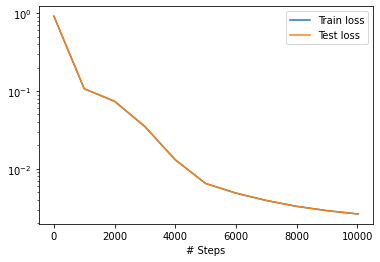

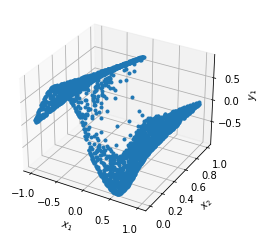

In [7]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Text(0, 0.5, 'X')

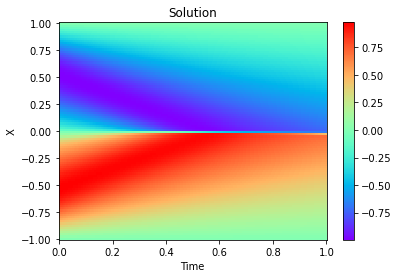

In [8]:
x = np.linspace(-1,1,100)
t = np.linspace(0,1,500)
X, T = np.meshgrid(x,t)
domain = np.vstack((np.ravel(X),np.ravel(T))).T
solution = model.predict(domain).reshape((len(t), len(x)))
error = np.abs(model.predict(domain,operator=pde).reshape((len(t), len(x))))

import matplotlib.pyplot as plt
plt.pcolormesh(T, X, solution, cmap='rainbow')
plt.colorbar()
plt.title('Solution')
plt.xlabel('Time')
plt.ylabel('X')

Text(0, 0.5, 'X')

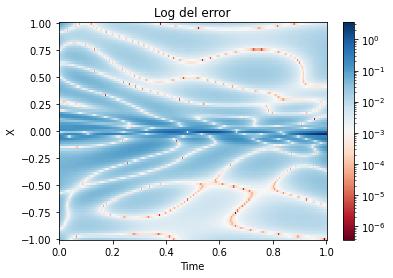

In [9]:
import matplotlib
plt.pcolormesh(T, X, error, cmap='RdBu', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.title('Log del error')
plt.xlabel('Time')
plt.ylabel('X')